<a href="https://colab.research.google.com/github/martingrzzler/colab-notebooks/blob/master/deep_learning_foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('sample_data/mnist_train_small.csv')
test_data = pd.read_csv('sample_data/mnist_test.csv')

In [3]:
data_np = data.to_numpy()
test_data_np = test_data.to_numpy()
data_np.shape, test_data_np.shape

((19999, 785), (9999, 785))

In [4]:
Y = data_np[:,0]
X = data_np[:,1:]
Y_test = test_data_np[:,0]
X_test = test_data_np[:,1:]
N = X.shape[0]

In [5]:
dims = np.sqrt(X[0].shape[0]).astype(int)

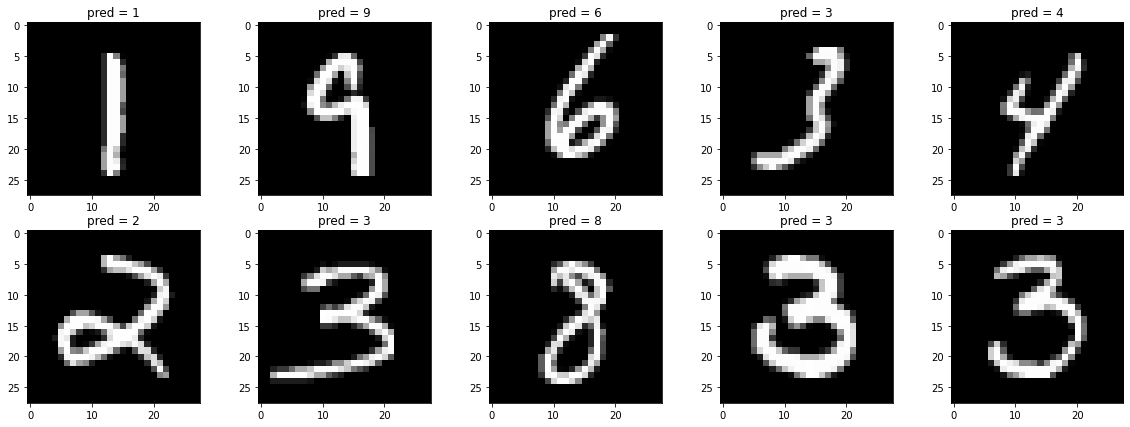

In [6]:
fig, axs = plt.subplots(2,5,figsize=(20,7))
for ax in axs.flat:
  index = np.random.randint(0, N)
  img = X[index].reshape((dims,dims))
  ax.set_title(f"pred = {Y[index]}")
  ax.imshow(img, cmap='gray', vmin=0, vmax=255)


(array([1962., 2243., 1989., 2021., 1924., 1761., 2038., 2126., 1912.,
        2023.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

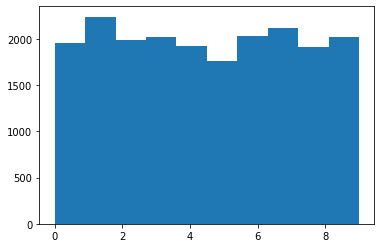

In [7]:
plt.hist(Y, bins=10)
# evenly distributed

In [8]:
X_norm = X / np.max(X)
X_test_norm = X_test / np.max(X_test)

Now that I have labels and training data let's build the Neural Network.

### Cost function and Gradient Descent

This is a categorical problem so I will use the `Cross Entropy Function`. Why choosing any particular cost function? Minimizing the cost is the same as finding a solution to a maximum likelihood problem. The likelihood tells us how likely it is that the data can be modeled by a particular distribution with certain parameters. Depending on what parameters one uses this liklihood will be bigger or smaller. In practice the likelyhood is the product over all datapoint's PDF function: $\prod_{i=1}^{N} PDF(x_i; w)$. In the case of a categorical distribution it is $\prod_{n=1}^{N}\prod_{k=1}^K p_k^{[t_n=k]}$. This is often transformed to the log likelihood which makes taking the derivative easier and numbers more stable as a product of probabilities becomes very small very fast.

$\sum_{n=1}^{N}\sum_{k=1}^K [t_n=k] \log(p_k)$

Now imagine the $p_k$ to be the probability the model predicts. If it predicts one for the correct target it outputs zero. If it predicts 0.5 for the correct target the win will be $1 \log(0.5) = -0.693$. So as the prediciton goes more wrong the win drops as well. Notice in order to turn this into a loss function rather than "win" function, simply add a negative sign. In that case 0.6 will mean a higher loss than 0. Without the negative sigm one must go uphill when doing gradient descent.

### Architecure

<img width="300" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/basic-nn.png" />

#### Definitions
$D=784$ - number of input features

$M=16$ - number of hidden layer nodes

$K=10$ - number of output nodes

Forward pass:

$α=W^Tx+b$

$z=σ(α)$

$a=V^Tz+c$

$y=softmax(a)$

$J=\sum_{n=1}^N\sum_{k=1}^Kt_{nk}log(y_{nk})$ - the loss function
#### Derivatives
_Softmax_:


$\frac{δJ}{δa_{nk}}=∑^N_{n=1}∑_{k'=1}^K\frac{δJ}{δy_{nk'}}\frac{δy_{nk'}}{δa_{nk}}$

$\frac{δJ}{δa_{nk}}=y_{nk'}(𝛅-y_{nk})$

$𝜹=\binom{k'=k→1}{k'!=k→0}$

<img width="500" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/softmax_derivative.jpg" />

_Cross Entropy Loss_:

$\frac{δJ}{δy_{nk'}}=\frac{t_{nk'}}{y_{nk'}}$

Bringing them together:

$\sum_{n=1}^N\sum_{k'=1}^Kt_{nk'}(𝛅_{kk'}-y_nk)$

split the sum

1. $\sum_{k'=1}^Kt_{k'}𝛅_{kk'}=t_k$ because $t_k*1 + 0 = t_k$


2. $\sum_{k'=1}^Kt_{k'}y_{k}=y_k\sum_{k'=1}^Kt_k'=y_k*1=y_k$


$\sum_{n=1}^N(t_{nk}-y_{nk})$

$𝚫J=X^T(T-Y)$


_Sigmoid_:

<img width="250" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/sigmoid_derivative.jpg" />

so the derivatives for $c,V,b,W$:

$δJ/δV_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})z_{nm}$

$δJ/δc_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})$

$δJ/δW_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})x_{nd}$

$δJ/δb_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})$






In [37]:
def cost(T, Y):
  tot = T * np.log(Y)
  return tot.sum()

def forward(X, W, b, V, c):
  Z = 1 / (1 + np.exp(-X.dot(W) - b))
  A = Z.dot(V) + c
  expA = np.exp(A)
  Y = expA / expA.sum(axis=1, keepdims=True)
  return Y, Z

def derivative_V(Z, T, Y):
  return Z.T.dot(T - Y)

def derivative_c(T, Y):
  return (T - Y).sum(axis=0)

def derivative_W(X, Z, T, Y, V):
    dZ = (T - Y).dot(V.T) * Z * (1 - Z)
    return X.T.dot(dZ)

def derivative_b(T, Y, V, Z):
    return ((T - Y).dot(V.T) * Z * (1 - Z)).sum(axis=0)

def accuracy(Y, P):
  return np.mean(Y==P)


def to_indicator(Y, K):
  T = np.zeros((len(Y),K))
  for n in range(len(Y)):
    T[n,Y[n]] = 1
  return T

def unison_shuffle(A, B, C):
  assert(len(A) == len(B) == len(C))
  p = np.random.permutation(len(A))
  return A[p], B[p], C[p]


epoch: 0 win: -132639.10989774988 accuracy: 0.08620431021551078
epoch: 20 win: -41451.89263879917 accuracy: 0.20611030551527576
epoch: 40 win: -39060.14246330662 accuracy: 0.23356167808390418
epoch: 60 win: -39320.283844582555 accuracy: 0.3872193609680484
epoch: 80 win: -26351.16331265908 accuracy: 0.43412170608530426
epoch: 100 win: -26600.950026032897 accuracy: 0.5138256912845642
epoch: 120 win: -21176.796299691192 accuracy: 0.6083304165208261
epoch: 140 win: -20206.101214723316 accuracy: 0.6500325016250813
epoch: 160 win: -16351.244705183675 accuracy: 0.7219860993049653
epoch: 180 win: -15169.07311884723 accuracy: 0.7312365618280914
epoch: 200 win: -13099.390027723945 accuracy: 0.7924896244812241
epoch: 220 win: -10984.754235949218 accuracy: 0.8137406870343518
epoch: 240 win: -11591.339364678359 accuracy: 0.8110405520276014
epoch: 260 win: -11267.63988995474 accuracy: 0.815540777038852
epoch: 280 win: -10563.917761843597 accuracy: 0.823941197059853
epoch: 300 win: -9937.195516053765

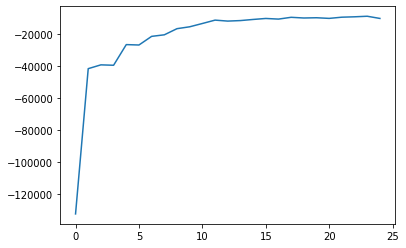

In [10]:
D = X[0].shape[0]
M = 16
K = 10
T = to_indicator(Y, K)

# initialize weights
W = np.random.randn(D, M)
b = np.zeros(M)
V = np.random.randn(M, K)
c = np.zeros(K)

learning_rate = 0.001
costs = []
batch_size = 256

for epoch in range(500):
  output, hidden = forward(X_norm, W, b, V, c)

  if epoch % 20 == 0:
    win = cost(T, output)
    P = np.argmax(output, axis=1)
    print("epoch:", epoch, "win:", win, "accuracy:", accuracy(Y,P))
    costs.append(win)

  gV = derivative_V(hidden,T, output)  
  gc = derivative_c(T,output)  
  gW = derivative_W(X_norm,hidden,T,output,V) 
  gb = derivative_b(T, output, V, hidden)  

  V += learning_rate * gV
  c += learning_rate * gc
  W += learning_rate * gW
  b += learning_rate * gb

# test accuracy
P_test_proba, _ = forward(X_test_norm, W, b, V, c)
P_test = np.argmax(P_test_proba, axis=1)
print("test accuracy:", accuracy(Y_test, P_test))

plt.plot(costs)
plt.show()

### Generalizing to arbitrary layer size

<div>
  <img width="400" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/two-hidden-layer.png" />
  <img width="400" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/three-layer-functions.png" />
</div>

<img width="700" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/first-layer-derivative.png" />

Consider one weight $W_{dm^{(1)}}^{(1)}$, so connecting the input layer to the first hidden layer. This directly only influences the current $a_{nm^{(1)}}^{(1)}$. In turn this only influences the activation $z_{nm^{(1)}}^{(1)}$. Now however all $a_{nm^{(2)}}^{(2)}$ are directly influenced. Realize that a tiny change in the first layer influences everything that comes after.

_The derivatives_

<img width="700" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/three-derivatives.png" />

_The following pattern emerges_:

$𝜟_{W^{(l)}}J=Z^{(l-1)T}𝛅^{(l)}$

For any weight matrix $W^{(l)}$ it't gradient is the input into the current layer times some $𝛅$.

In [29]:
def sigmoid(A):
  return 1 / (1 + np.exp(-A))

def softmax(A):
  expA = np.exp(A)
  return expA / np.sum(expA, axis=1, keepdims=True)

class ANN:
  @staticmethod
  def forward_hidden(X, W, b):
    return sigmoid(X.dot(W) + b)
  
  @staticmethod
  def forward_output(X, W, b):
    return softmax(X.dot(W) + b)

In [36]:
D = X[0].shape[0]
M = 16
K = 10
T = to_indicator(Y, N, K)

num_layers = 4
L = num_layers - 1

# initialize weights

W = [np.random.randn(M,M) for i in range(L - 2)]
W.insert(0,np.random.randn(D,M))
W.append(np.random.randn(M,K))

b = [np.zeros((M)) for i in range(L - 1)]
b.append(np.zeros(K))

learning_rate = 0.001
costs = []

Z = [0 for i in range(L)]
 
for epoch in range(1):
  # forward pass
  Z[0] = ANN.forward_hidden(X_norm, W[0], b[0])
  for i in range(1, L - 1):
    Z[i] = ANN.forward_hidden(Z[i - 1], W[i], b[i])
  Z[-1] = ANN.forward_output(Z[-2], W[-1], b[-1])
  output = Z[-1]

  

    
  

#   output, hidden = forward(X_norm, W, b, V, c)

#   if epoch % 20 == 0:
#     win = cost(T, output)
#     P = np.argmax(output, axis=1)
#     print("epoch:", epoch, "win:", win, "accuracy:", accuracy(Y,P))
#     costs.append(win)

#   gV = derivative_V(hidden,T, output)  
#   gc = derivative_c(T,output)  
#   gW = derivative_W(X_norm,hidden,T,output,V) 
#   gb = derivative_b(T, output, V, hidden)  

#   V += learning_rate * gV
#   c += learning_rate * gc
#   W += learning_rate * gW
#   b += learning_rate * gb

# # test accuracy
# P_test_proba, _ = forward(X_test_norm, W, b, V, c)
# P_test = np.argmax(P_test_proba, axis=1)
# print("test accuracy:", accuracy(Y_test, P_test))

# plt.plot(costs)
# plt.show()

(19999, 10)


3